In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cpu'

In [ ]:
class Generator(nn.Module):
  def __init__(self,input_size, hidden_size, output_size, num_classes):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(input_size + num_classes, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
    self.fc3 = nn.Linear(hidden_size * 2, output_size)
    self.activation = nn.ReLU()
    # Initialize weights
    nn.init.xavier_uniform_(self.fc1.weight)
    nn.init.xavier_uniform_(self.fc2.weight)
    nn.init.xavier_uniform_(self.fc3.weight)


  def forward(self,x,y):
    # Reshape y to have the same number of dimensions as the concatenated dimension in x
    #y = y.view(y.size(0), -1)  # Reshape y to (100, 1)
    # Concatenate random noise vectors with class labels
    x = torch.cat([x, y], dim=1)
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    x = self.activation(x)
    x = self.fc3(x)
    x = torch.tanh(x)
    return x

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,input_size, hidden_size, output_size, num_classes):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(input_size + num_classes, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
    self.fc3 = nn.Linear(hidden_size * 2, output_size)
    self.activation = nn.ReLU()
    # Initialize weights
    nn.init.xavier_uniform_(self.fc1.weight)
    nn.init.xavier_uniform_(self.fc2.weight)
    nn.init.xavier_uniform_(self.fc3.weight)


  def forward(self,x,y):
    #print(x.shape)
    #print(y.shape)
    # Reshape y to have the same number of dimensions as the concatenated dimension in x
    #y = y.view(y.size(0), -1)  # Reshape y to (100, 1)
    #print(y.shape)
    # Concatenate images with class labels
    x = torch.cat([x, y], dim=1)
    #print(x.shape)
    #print(self.fc1.weight.shape)
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    x = self.activation(x)
    x = self.fc3(x)
    #x = torch.sigmoid(x)  # Sigmoid activation for binary classification # logits are used instead of probabilities for the discriminator's output
    return x

In [ ]:
# Generate random noise vectors
num_samples=10
latent_size = 64
num_classes = 10
# Generate random noise vectors
vis_noise = torch.randn(num_samples, latent_size).to(device)

# Generate labels in one hot encoding
vis_label = torch.randint(0,num_classes,(10,))
vis_label_reshape = vis_label.reshape(-1)
vis_label_one_hot = nn.functional.one_hot(vis_label_reshape,num_classes=num_classes).float().to(device)

# print the test labels
vis_label_display = vis_label.reshape(2,5)
print(vis_label_display)

tensor([[1, 8, 8, 7, 5],
        [1, 9, 0, 2, 2]])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to generate and visualize sample images
def visualize_samples(generator, num_samples=10, figsize=(5, 5), image_size=(28, 28)):
    # Generate random noise vectors
    #vis_noise = torch.randn(num_samples, latent_size).to(device)

    # Generate fake images from the noise vectors
    with torch.no_grad():
        #vis_label = torch.randint(0,num_classes,(10,)).reshape(-1)
        #vis_label = nn.functional.one_hot(vis_label,num_classes=num_classes).float().to(device)
        #generated_images = generator(noise, label).cpu()
        generated_images = generator(vis_noise, vis_label_one_hot).to(device)

    # Convert the generated images to numpy arrays and reshape them
    generated_images = generated_images.cpu()
    generated_images = generated_images.view(num_samples, *image_size).numpy()

    # Plot the generated images in a grid
    plt.figure(figsize=figsize)
    for i in range(num_samples):
        plt.subplot(10, 5, i + 1)
        #print(vis_label[i])
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def train(generator, discriminator, dataloader, num_epochs, batch_size, learning_rate, num_classes):
    #criterion = nn.BCELoss()
    criterion = nn.BCEWithLogitsLoss()  # Use logistic loss
    g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

    print('Input labels to generator for test and visualise after each epoch')
    print(vis_label_display)

    for epoch in range(num_epochs):
        for i, (real_images, labels) in enumerate(dataloader):
            #real_images, labels = data
            # Train discriminator
            discriminator.zero_grad()
            #real_images, _ = data
            real_images = real_images.view(real_images.size(0), -1)
            real_images = real_images.to(device)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Convert labels to one-hot encoding
            labels = nn.functional.one_hot(labels, num_classes=num_classes).float()

            # Move one-hot encoded labels to the device
            labels = labels.to(device)


            # Train discriminator on real data
            """
            print(real_images.size(0))
            print(labels.size(0))
            print(real_images.shape)
            print(labels.shape)
            #break
            """
            real_outputs = discriminator(real_images, labels)
            d_loss_real = criterion(real_outputs, real_labels)
            d_loss_real.backward()

            # Train discriminator on fake data
            z = torch.randn(batch_size, latent_size)
            z = z.to(device)
            fake_images = generator(z,labels)
            fake_outputs = discriminator(fake_images.detach(), labels)
            d_loss_fake = criterion(fake_outputs, fake_labels)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake
            d_optimizer.step()

            # Train generator
            generator.zero_grad()
            z = torch.randn(batch_size, latent_size)
            z = z.to(device)
            fake_images = generator(z, labels)
            outputs = discriminator(fake_images, labels)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()

            if (i+1) % 200 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                      f'D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}')

        # for every 20th epoch visualize test sample
        if epoch % 10 == 0:
          visualize_samples(generator)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 100
#mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_data = datasets.MNIST("./", train=True, download=True, transform=transform)
data_loader = DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)




Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 50447878.79it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1704480.07it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13299407.51it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4695718.21it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



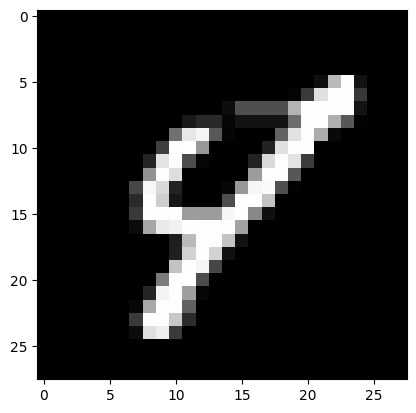

tensor(4)


In [ ]:
def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")
    plt.show()

images, labels = next(iter(data_loader))
plot_digit(images[1])
print(labels[1])

In [ ]:
# Hyperparameters
latent_size = 64
hidden_size = 256
image_size = 784  # 28x28 for MNIST
num_classes = 10  # Number of classes in the dataset

# Instantiate networks
generator = Generator(latent_size, hidden_size, image_size,num_classes)
generator = generator.to(device)
discriminator = Discriminator(image_size, hidden_size, 1, num_classes)
discriminator = discriminator.to(device)


Input labels to generator for test and visualise after each epoch
tensor([[1, 8, 8, 7, 5],
        [1, 9, 0, 2, 2]])
Epoch [1/50], Step [200/600], D_loss: 0.1186, G_loss: 4.0485
Epoch [1/50], Step [400/600], D_loss: 0.0274, G_loss: 6.9709
Epoch [1/50], Step [600/600], D_loss: 0.1101, G_loss: 5.5161


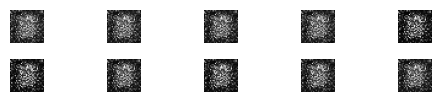

Epoch [2/50], Step [200/600], D_loss: 0.3219, G_loss: 4.6935
Epoch [2/50], Step [400/600], D_loss: 0.3314, G_loss: 2.8666
Epoch [2/50], Step [600/600], D_loss: 0.2781, G_loss: 5.4246
Epoch [3/50], Step [200/600], D_loss: 0.4926, G_loss: 3.4525
Epoch [3/50], Step [400/600], D_loss: 0.4386, G_loss: 4.4279
Epoch [3/50], Step [600/600], D_loss: 0.2419, G_loss: 5.2031
Epoch [4/50], Step [200/600], D_loss: 0.4017, G_loss: 4.7811
Epoch [4/50], Step [400/600], D_loss: 0.3654, G_loss: 4.0440
Epoch [4/50], Step [600/600], D_loss: 0.3089, G_loss: 3.4196
Epoch [5/50], Step [200/600], D_loss: 0.1581, G_loss: 4.0809
Epoch [5/50], Step [400/600], D_loss: 0.2215, G_loss: 5.8778
Epoch [5/50], Step [600/600], D_loss: 0.5934, G_loss: 3.3718
Epoch [6/50], Step [200/600], D_loss: 0.4011, G_loss: 3.4661
Epoch [6/50], Step [400/600], D_loss: 0.3505, G_loss: 3.4782
Epoch [6/50], Step [600/600], D_loss: 0.3640, G_loss: 3.7771
Epoch [7/50], Step [200/600], D_loss: 0.4603, G_loss: 3.5459
Epoch [7/50], Step [400/

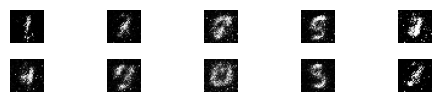

Epoch [22/50], Step [200/600], D_loss: 0.5341, G_loss: 3.4058
Epoch [22/50], Step [400/600], D_loss: 0.3375, G_loss: 4.4499
Epoch [22/50], Step [600/600], D_loss: 0.4553, G_loss: 3.3508
Epoch [23/50], Step [200/600], D_loss: 0.2219, G_loss: 3.4194
Epoch [23/50], Step [400/600], D_loss: 0.2362, G_loss: 5.6297
Epoch [23/50], Step [600/600], D_loss: 0.2922, G_loss: 3.8388
Epoch [24/50], Step [200/600], D_loss: 0.2633, G_loss: 6.3386
Epoch [24/50], Step [400/600], D_loss: 0.3328, G_loss: 5.0319
Epoch [24/50], Step [600/600], D_loss: 0.5086, G_loss: 2.6776
Epoch [25/50], Step [200/600], D_loss: 0.4919, G_loss: 4.4875
Epoch [25/50], Step [400/600], D_loss: 0.5169, G_loss: 4.6297
Epoch [25/50], Step [600/600], D_loss: 0.3514, G_loss: 5.0691
Epoch [26/50], Step [200/600], D_loss: 0.4866, G_loss: 3.5841
Epoch [26/50], Step [400/600], D_loss: 0.3053, G_loss: 4.4850
Epoch [26/50], Step [600/600], D_loss: 0.6658, G_loss: 3.1380
Epoch [27/50], Step [200/600], D_loss: 0.5286, G_loss: 4.2304
Epoch [2

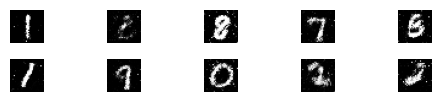

Epoch [42/50], Step [200/600], D_loss: 0.5131, G_loss: 2.4270
Epoch [42/50], Step [400/600], D_loss: 0.8086, G_loss: 3.1006
Epoch [42/50], Step [600/600], D_loss: 0.6202, G_loss: 2.3057
Epoch [43/50], Step [200/600], D_loss: 0.8096, G_loss: 1.9410
Epoch [43/50], Step [400/600], D_loss: 0.6966, G_loss: 2.5307
Epoch [43/50], Step [600/600], D_loss: 0.9150, G_loss: 1.6311
Epoch [44/50], Step [200/600], D_loss: 0.7399, G_loss: 2.7336
Epoch [44/50], Step [400/600], D_loss: 0.7240, G_loss: 2.3761
Epoch [44/50], Step [600/600], D_loss: 0.7942, G_loss: 2.3901
Epoch [45/50], Step [200/600], D_loss: 0.6100, G_loss: 3.0090
Epoch [45/50], Step [400/600], D_loss: 0.5622, G_loss: 3.0867
Epoch [45/50], Step [600/600], D_loss: 0.8120, G_loss: 2.1153
Epoch [46/50], Step [200/600], D_loss: 0.7553, G_loss: 2.3199
Epoch [46/50], Step [400/600], D_loss: 0.7075, G_loss: 2.0507
Epoch [46/50], Step [600/600], D_loss: 0.6377, G_loss: 2.0468
Epoch [47/50], Step [200/600], D_loss: 0.7090, G_loss: 2.3970
Epoch [4

In [ ]:
num_epochs = 50
learning_rate = 0.0002


train(generator, discriminator, data_loader, num_epochs, batch_size, learning_rate, num_classes)


tensor([[1, 8, 8, 7, 5],
        [1, 9, 0, 2, 2]])


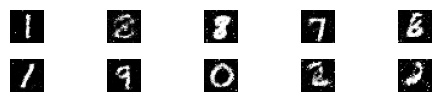

In [ ]:
print(vis_label_display)

# Generate and visualize sample images
visualize_samples(generator)